In [1]:
!pip install -U transformers sentence-transformers huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 96.8 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 36.7 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.1
    Uninstalling transformers-4.57.1:
      Successfully uninstalled transformers-4.57.1
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 5.1.1
    Uninstalling sentence-transformers-5.1.1:
      Successfully uninstalled sentence-transformers-5.1.1


In [2]:
!pip install google-genai faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 80.4 MB/s eta 0:00:00:00:0100:01


In [8]:
import numpy as np
import random
import re
from collections import defaultdict
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import json
from google import genai
from google.genai import types
from google.api_core.exceptions import ResourceExhausted, ServiceUnavailable
import time, random
import faiss

In [ ]:
client = genai.Client(api_key='set-api-key')

In [10]:
# Sample document

french_revolution_document = """
The French Revolution was a period of radical political and societal change in France 
that began with the Estates-General of 1789 and lasted until 1799. The revolution was 
triggered by a severe financial crisis that had plagued the French monarchy for decades. 
King Louis XVI, facing bankruptcy, was forced to convene the Estates-General in May 1789 
for the first time since 1614. This assembly represented the three estates of French 
society: the clergy, the nobility, and the commoners known as the Third Estate.

The Estates-General quickly became a battleground for reform. The Third Estate, representing 
98% of the population, demanded greater representation and voting power. When their demands 
were rejected, they broke away and formed the National Assembly in June 1789, declaring 
themselves the legitimate government of France. King Louis XVI responded by gathering troops 
around Paris, which the people interpreted as preparation for a military crackdown.

Tensions exploded on July 14, 1789, when a mob stormed the Bastille, a royal fortress and 
prison in Paris. This event symbolized the fall of royal authority and is celebrated to this 
day as Bastille Day, France's national holiday. The storming was a direct response to fears 
that the king would use military force against the National Assembly. The success of this 
popular uprising emboldened revolutionaries across France.

The revolution gradually became more radical. By 1792, the monarchy was abolished and France 
was declared a republic. King Louis XVI was tried for treason and executed by guillotine in 
January 1793. This execution shocked European monarchies and led to war between France and 
various European coalitions seeking to restore the monarchy.

The period from 1793 to 1794 became known as the Reign of Terror, the most violent phase 
of the revolution. Led by Maximilien Robespierre and the Committee of Public Safety, the 
revolutionary government executed thousands of people deemed enemies of the revolution. 
Approximately 17,000 people were officially sentenced to death, while thousands more died 
in prison or without trial. The guillotine became the symbol of this period, used to execute 
nobles, clergy, and eventually even fellow revolutionaries who were accused of not being 
radical enough.

Robespierre, initially seen as an incorruptible champion of the people, became increasingly 
dictatorial. He advocated for the Republic of Virtue and the worship of the Supreme Being, 
attempting to replace Christianity with a new civic religion. However, his extreme measures 
and paranoid purges eventually turned his allies against him. In July 1794, in what became 
known as the Thermidorian Reaction, Robespierre was arrested and executed by the same 
guillotine he had used to eliminate his enemies. His death marked the end of the Terror.

The revolution continued through various phases until Napoleon Bonaparte, a successful 
military general, seized power in a coup d'état in November 1799. Napoleon's rise marked 
the end of the revolutionary period and the beginning of the Napoleonic Era. He would 
eventually crown himself Emperor of France in 1804, bringing a form of monarchy back to 
France, though fundamentally transformed by revolutionary principles.
"""

In [11]:
def extract_concepts(document):
    prompt = f"""
                Read this document and identify the KEY CONCEPTS that should be 
                explained separately. For each concept, explain why it's important.
                
                Document: {document}
                
                Return format:
                - Concept Name
                - Why it's important
                - Related concepts
                - Keywords

                An example output is:
                {{
                    "name": "Estates-General_1789",
                    "importance": "The triggering event that started the revolution",
                    "related_concepts": ["Financial_Crisis", "Louis_XVI", "National_Assembly"],
                    "keywords": ["Estates-General", "1789", "convened", "financial crisis"]
                }}
                
                **ONLY GIVE THE CONCEPTS INSIDE THAT ARE MENTIONED IN THE DOCUMENT**
            """

    response = client.models.generate_content(
        model='gemini-2.5-pro',
        contents=prompt,
        config=types.GenerateContentConfig(
            temperature=0.1,
        )
    )

    if response.text:
        answer = response.text.strip()

    return answer if answer else 'No answer'

_last_call_time = 0

def extract_text_for_concept(document, concept, max_retries=4, min_gap=3):
    global _last_call_time
    prompt = f"""
        Read the following document and extract only the sentences or paragraphs
        that describe or relate to the concept: "{concept['name']}".
        Use the concept's keywords to identify relevant passages.

        Document: {document}

        Return only the extracted text. If no direct text is found, say:
        "(No direct references found for {concept['name']})"
    """

    for attempt in range(1, max_retries + 1):
        try:
            # simple rate limiting: wait a few seconds between calls
            elapsed = time.time() - _last_call_time
            if elapsed < min_gap:
                time.sleep(min_gap - elapsed)

            response = client.models.generate_content(
                model='gemini-2.5-pro',
                contents=prompt,
                config=types.GenerateContentConfig(temperature=0.1)
            )

            _last_call_time = time.time()
            return response.text.strip() if response.text else f"(No text found for {concept['name']})"

        except (ResourceExhausted, ServiceUnavailable):
            wait = min(30, 2 ** attempt + random.random())
            print(f"Gemini overloaded (attempt {attempt}) — retrying in {wait:.1f}s...")
            time.sleep(wait)

    return f"(Failed after {max_retries} retries for {concept['name']})"

In [12]:
concepts_json = extract_concepts(french_revolution_document)

In [13]:
concepts_cleaned = re.sub(r"^```json|```$", "", concepts_json.strip(), flags=re.MULTILINE).strip()
concepts = json.loads(concepts_cleaned)

In [14]:
print(json.dumps(concepts, indent=4, ensure_ascii=False))

[
    {
        "name": "Estates-General_of_1789",
        "importance": "This assembly was the direct trigger for the revolution. Convened by King Louis XVI to solve a financial crisis, its outdated structure and voting rules caused the Third Estate to break away and form the National Assembly, initiating the challenge to royal authority.",
        "related_concepts": [
            "Financial_Crisis",
            "King_Louis_XVI",
            "Third_Estate",
            "National_Assembly"
        ],
        "keywords": [
            "Estates-General",
            "1789",
            "convened",
            "three estates",
            "financial crisis"
        ]
    },
    {
        "name": "Third_Estate",
        "importance": "As the representative body for 98% of the French population (the commoners), its demand for fair representation and its subsequent transformation into the National Assembly was the driving force that started the revolution.",
        "related_concepts": [
  

In [15]:
# Build Concept-Based Knowledge Graph

print("="*80)
print("STEP 1: LLM Extracts Concepts from Document")
print("="*80)

print(f"\nFound {len(concepts)} key concepts:\n")
for i, concept in enumerate(concepts, 1):
    print(f"{i}. {concept['name']}")
    print(f"   Importance: {concept['importance']}")
    print(f"   Related to: {', '.join(concept['related_concepts'][:3])}")
    print(f"   Keywords: {', '.join(concept['keywords'][:3])}")
    print()

STEP 1: LLM Extracts Concepts from Document

Found 9 key concepts:

1. Estates-General_of_1789
   Importance: This assembly was the direct trigger for the revolution. Convened by King Louis XVI to solve a financial crisis, its outdated structure and voting rules caused the Third Estate to break away and form the National Assembly, initiating the challenge to royal authority.
   Related to: Financial_Crisis, King_Louis_XVI, Third_Estate
   Keywords: Estates-General, 1789, convened

2. Third_Estate
   Importance: As the representative body for 98% of the French population (the commoners), its demand for fair representation and its subsequent transformation into the National Assembly was the driving force that started the revolution.
   Related to: Estates-General_of_1789, National_Assembly
   Keywords: Third Estate, commoners, 98% of the population

3. National_Assembly
   Importance: This was the first revolutionary government, formed by the Third Estate. By declaring itself the legitim

In [16]:
# Extract chunks based on concepts

print("="*80)
print("STEP 2: Extract Text Chunks for Each Concept")
print("HYBRID MCMC-ACO-VECTOR RETRIEVAL SYSTEM")
print("="*80)

chunks = []
chunk_to_concept = {}
concept_to_chunk_id = {}

for i, concept in enumerate(concepts):
    chunk_text = extract_text_for_concept(french_revolution_document, concept)
    chunks.append(chunk_text)
    chunk_to_concept[i] = concept['name']
    concept_to_chunk_id[concept['name']] = i
    
    print(f"\nChunk {i}: {concept['name']}")
    print(f"Text preview: {chunk_text[:150]}...")

    time.sleep(random.uniform(4, 8))

N = len(chunks)
print(f"\nCreated {N} concept-based chunks")

STEP 2: Extract Text Chunks for Each Concept
HYBRID MCMC-ACO-VECTOR RETRIEVAL SYSTEM

Chunk 0: Estates-General_of_1789
Text preview: The French Revolution was a period of radical political and societal change in France that began with the Estates-General of 1789 and lasted until 179...

Chunk 1: Third_Estate
Text preview: This assembly represented the three estates of French society: the clergy, the nobility, and the commoners known as the Third Estate.

The Third Estat...

Chunk 2: National_Assembly
Text preview: The Estates-General quickly became a battleground for reform. The Third Estate, representing 98% of the population, demanded greater representation an...

Chunk 3: Storming_of_the_Bastille
Text preview: Tensions exploded on July 14, 1789, when a mob stormed the Bastille, a royal fortress and 
prison in Paris. This event symbolized the fall of royal au...

Chunk 4: Execution_of_Louis_XVI
Text preview: King Louis XVI was tried for treason and executed by guillotine in January 1

In [17]:
# Build graph
P_concept = np.zeros((N, N), dtype=float)

for i, concept in enumerate(concepts):
    related = concept['related_concepts']
    linked_chunk_ids = []
    
    for related_name in related:
        if related_name in concept_to_chunk_id:
            j = concept_to_chunk_id[related_name]
            linked_chunk_ids.append(j)
    
    if linked_chunk_ids:
        prob = 1.0 / len(linked_chunk_ids)
        for j in linked_chunk_ids:
            P_concept[i, j] = prob

for i in range(N):
    if P_concept[i].sum() == 0:
        P_concept[i, :] = 1.0 / N

print(f"Graph edges: {np.count_nonzero(P_concept)}")

# Encode Chunks

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(chunks, show_progress_bar=False)

Graph edges: 24


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [18]:
# Query
query = "How did the government structure change?"
print(f"\nQuery: {query}")

q_embedding = model.encode([query]).astype("float32")

faiss.normalize_L2(q_embedding)

embeddings = embeddings.astype("float32")
faiss.normalize_L2(embeddings)

dim = embeddings.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(embeddings)

k = len(embeddings)
cosine_scores, indices = index.search(q_embedding, k)

cosine_scores = cosine_scores[0]
indices = indices[0]


Query: How did the government structure change?


In [ ]:
# Simpler query without faiss

query = "How did the government structure change?"

print(f"\nQuery: {query}")

q_embedding = model.encode([query])
cosine_scores = cosine_similarity(q_embedding, embeddings).ravel()

In [19]:
# Phase 1: MCMC Initialization (PageRank-style)

print("\n" + "="*80)
print("PHASE 1: MCMC (Monte Carlo Markov Chain) Initialization")
print("="*80)

def mcmc_pagerank(initial_scores, P_graph, alpha=0.85, iterations=50):
    """
    Run MCMC to spread initial scores through graph structure.
    This is essentially personalized PageRank.
    """
    scores = initial_scores.copy()
    scores = scores / scores.sum()  # normalize
    
    for _ in range(iterations):
        # PageRank update: jump to neighbors with prob alpha, teleport with prob (1-alpha)
        scores = alpha * (P_graph.T @ scores) + (1 - alpha) * initial_scores
        scores = scores / scores.sum()
    
    return scores

mcmc_scores = mcmc_pagerank(cosine_scores, P_concept, alpha=0.85, iterations=50)

print("\nTop concepts after MCMC (graph-propagated relevance):")
for i in np.argsort(mcmc_scores)[::-1][:5]:
    print(f"  {chunk_to_concept[i]}: {mcmc_scores[i]:.4f} (cosine: {cosine_scores[i]:.4f})")


PHASE 1: MCMC (Monte Carlo Markov Chain) Initialization

Top concepts after MCMC (graph-propagated relevance):
  National_Assembly: 0.2612 (cosine: 0.2749)
  Third_Estate: 0.1917 (cosine: 0.2912)
  Storming_of_the_Bastille: 0.1259 (cosine: 0.1635)
  Estates-General_of_1789: 0.1221 (cosine: 0.3334)
  Reign_of_Terror: 0.0945 (cosine: 0.1065)


In [20]:
# PHASE 2: ACO Refinement

print("\n" + "="*80)
print("PHASE 2: ACO (Ant Colony Optimization) Exploration")
print("="*80)

num_ants = 400
walk_length = 8
iterations = 80
alpha_aco = 1.0
beta_aco = 2.5
evaporation = 0.06
deposit_amount = 1.0

# Initialize pheromone with MCMC scores (instead of uniform)
pheromone = mcmc_scores * 100  # scale up for ACO dynamics

def transition_probs(current, pheromone, P_row, alpha, beta, teleport_prob=0.1):
    weighted = (pheromone ** alpha) * (P_row ** beta)
    if weighted.sum() == 0:
        probs = np.ones(len(weighted)) / len(weighted)
    else:
        probs = weighted / weighted.sum()
    if teleport_prob > 0:
        probs = (1 - teleport_prob) * probs + teleport_prob * (np.ones_like(probs) / len(probs))
    return probs

random.seed(42)
np.random.seed(42)

# Use MCMC scores as starting distribution for ants
start_prob = mcmc_scores / mcmc_scores.sum()

print(f"Running ACO with MCMC-initialized pheromones...")

for it in range(iterations):
    for ant in range(num_ants):
        cur = np.random.choice(N, p=start_prob)
        
        for step in range(walk_length):
            pheromone[cur] += deposit_amount
            probs = transition_probs(cur, pheromone, P_concept[cur], alpha_aco, beta_aco, teleport_prob=0.1)
            cur = np.random.choice(N, p=probs)
        
        pheromone[cur] += deposit_amount
    
    pheromone = (1 - evaporation) * pheromone

aco_scores = pheromone / pheromone.sum()

print("\nTop concepts after ACO:")
for i in np.argsort(aco_scores)[::-1][:5]:
    print(f"  {chunk_to_concept[i]}: {aco_scores[i]:.4f}")


PHASE 2: ACO (Ant Colony Optimization) Exploration
Running ACO with MCMC-initialized pheromones...

Top concepts after ACO:
  National_Assembly: 0.2812
  Third_Estate: 0.1985
  Maximilien_Robespierre: 0.1194
  Reign_of_Terror: 0.1185
  Thermidorian_Reaction: 0.1120


In [21]:
# PHASE 3: Hybrid Scoring (Multiplication)

print("\n" + "="*80)
print("PHASE 3: Hybrid Scoring (ACO × Cosine Similarity)")
print("="*80)

# Weighted combination with multiplication
alpha_weight = 0.7  # ACO importance
beta_weight = 0.8   # Cosine importance

hybrid_scores = (aco_scores ** alpha_weight) * (cosine_scores ** beta_weight)
hybrid_scores = hybrid_scores / hybrid_scores.sum()

print("\nScoring formula: (ACO^0.7) × (Cosine^0.8)")


PHASE 3: Hybrid Scoring (ACO × Cosine Similarity)

Scoring formula: (ACO^0.7) × (Cosine^0.8)


In [22]:
# Results Comparison

print("\n" + "="*80)
print("RESULTS COMPARISON")
print("="*80)

topk = 5

methods = {
    "Cosine Only": cosine_scores,
    "MCMC (PageRank-style)": mcmc_scores,
    "ACO Only": aco_scores,
    "HYBRID (ACO × Cosine)": hybrid_scores
}

for method_name, scores in methods.items():
    print(f"\n{'-'*80}")
    print(f"{method_name}")
    print(f"{'-'*80}")
    
    order = np.argsort(scores)[::-1][:topk]
    
    for rank, idx in enumerate(order, 1):
        concept_name = chunk_to_concept[idx]
        
        print(f"\n{rank}. {concept_name}")
        print(f"   Score: {scores[idx]:.4f}")
        print(f"   Cosine: {cosine_scores[idx]:.4f} | ACO: {aco_scores[idx]:.4f}")
        
        # Show graph centrality
        in_degree = np.count_nonzero(P_concept[:, idx])
        out_degree = np.count_nonzero(P_concept[idx, :])
        print(f"   Graph: {in_degree} incoming, {out_degree} outgoing links")


RESULTS COMPARISON

--------------------------------------------------------------------------------
Cosine Only
--------------------------------------------------------------------------------

1. Estates-General_of_1789
   Score: 0.3334
   Cosine: 0.3334 | ACO: 0.0463
   Graph: 2 incoming, 2 outgoing links

2. Third_Estate
   Score: 0.2912
   Cosine: 0.2912 | ACO: 0.1985
   Graph: 3 incoming, 2 outgoing links

3. National_Assembly
   Score: 0.2749
   Cosine: 0.2749 | ACO: 0.2812
   Graph: 4 incoming, 2 outgoing links

4. Storming_of_the_Bastille
   Score: 0.1635
   Cosine: 0.1635 | ACO: 0.1016
   Graph: 2 incoming, 1 outgoing links

5. Execution_of_Louis_XVI
   Score: 0.1466
   Cosine: 0.1466 | ACO: 0.0120
   Graph: 1 incoming, 2 outgoing links

--------------------------------------------------------------------------------
MCMC (PageRank-style)
--------------------------------------------------------------------------------

1. National_Assembly
   Score: 0.2612
   Cosine: 0.2749 

In [23]:
# Analysis: Where Hybrid Wins

print("\n" + "="*80)
print("ANALYSIS: Why Hybrid Outperforms")
print("="*80)

# Find chunks where hybrid ranking differs most from individual methods
print("\nConcepts where HYBRID differs from Cosine-only:")

cosine_ranks = {idx: rank for rank, idx in enumerate(np.argsort(cosine_scores)[::-1])}
hybrid_ranks = {idx: rank for rank, idx in enumerate(np.argsort(hybrid_scores)[::-1])}

improvements = []
for idx in range(N):
    cosine_rank = cosine_ranks[idx]
    hybrid_rank = hybrid_ranks[idx]
    
    if cosine_rank - hybrid_rank >= 2:  # Improved by 2+ positions
        improvements.append((idx, cosine_rank - hybrid_rank))

if improvements:
    print("\n✓ Concepts BOOSTED by hybrid (high graph centrality + decent query match):")
    for idx, boost in sorted(improvements, key=lambda x: x[1], reverse=True)[:3]:
        concept_name = chunk_to_concept[idx]
        print(f"  → {concept_name}")
        print(f"     Moved up {boost} positions")
        print(f"     Why: ACO={aco_scores[idx]:.4f} (graph central) × Cosine={cosine_scores[idx]:.4f} (query relevant)")


ANALYSIS: Why Hybrid Outperforms

Concepts where HYBRID differs from Cosine-only:

✓ Concepts BOOSTED by hybrid (high graph centrality + decent query match):
  → National_Assembly
     Moved up 2 positions
     Why: ACO=0.2812 (graph central) × Cosine=0.2749 (query relevant)
  → Maximilien_Robespierre
     Moved up 2 positions
     Why: ACO=0.1194 (graph central) × Cosine=0.1065 (query relevant)


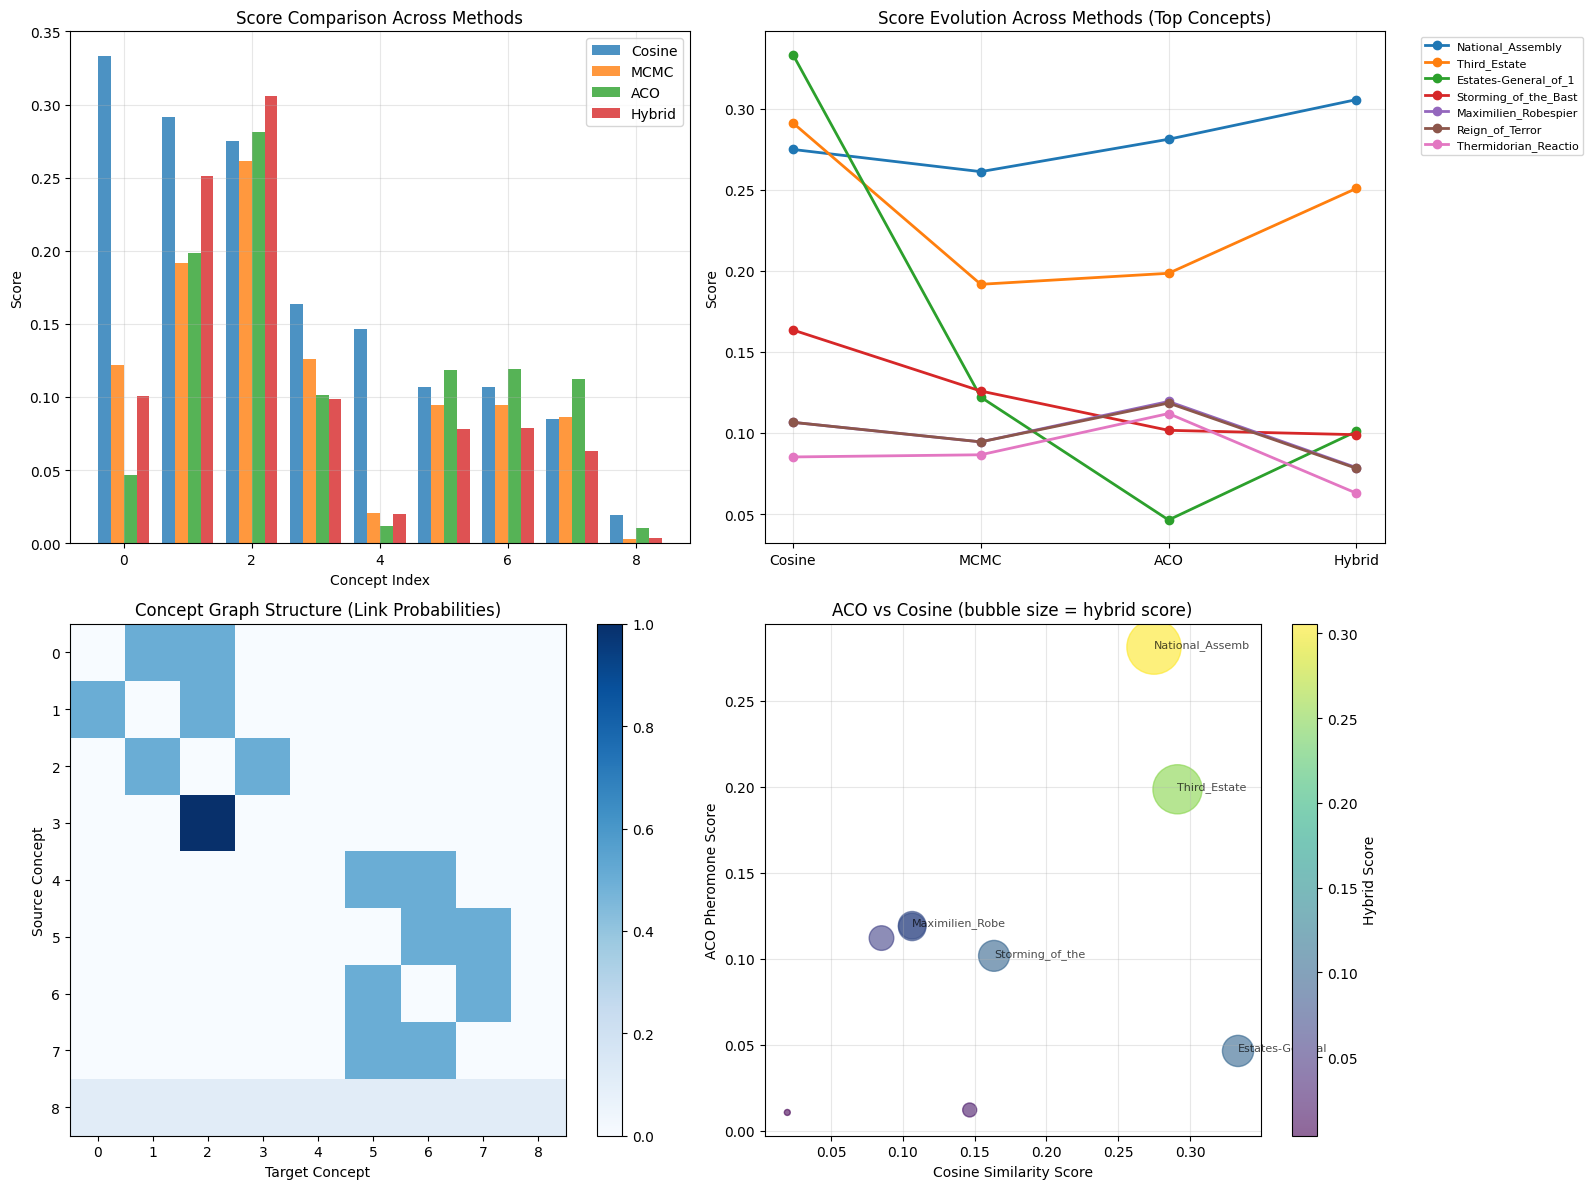

In [24]:
# Visualization

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Score comparison
ax = axes[0, 0]
x = np.arange(N)
width = 0.2

ax.bar(x - width*1.5, cosine_scores, width, label='Cosine', alpha=0.8)
ax.bar(x - width*0.5, mcmc_scores, width, label='MCMC', alpha=0.8)
ax.bar(x + width*0.5, aco_scores, width, label='ACO', alpha=0.8)
ax.bar(x + width*1.5, hybrid_scores, width, label='Hybrid', alpha=0.8)

ax.set_xlabel('Concept Index')
ax.set_ylabel('Score')
ax.set_title('Score Comparison Across Methods')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Ranking comparison for top concepts
ax = axes[0, 1]
concept_names = [chunk_to_concept[i] for i in range(N)]
top_concepts_idx = np.argsort(hybrid_scores)[::-1][:7]

for i, idx in enumerate(top_concepts_idx):
    name = concept_names[idx]
    scores_list = [cosine_scores[idx], mcmc_scores[idx], aco_scores[idx], hybrid_scores[idx]]
    ax.plot(['Cosine', 'MCMC', 'ACO', 'Hybrid'], scores_list, marker='o', label=name[:20], linewidth=2)

ax.set_ylabel('Score')
ax.set_title('Score Evolution Across Methods (Top Concepts)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 3: Graph visualization (adjacency matrix)
ax = axes[1, 0]
im = ax.imshow(P_concept, cmap='Blues', aspect='auto')
ax.set_xlabel('Target Concept')
ax.set_ylabel('Source Concept')
ax.set_title('Concept Graph Structure (Link Probabilities)')
plt.colorbar(im, ax=ax)

# Plot 4: Scatter: ACO vs Cosine (with hybrid as size)
ax = axes[1, 1]
scatter = ax.scatter(cosine_scores, aco_scores, s=hybrid_scores*5000, alpha=0.6, c=hybrid_scores, cmap='viridis')

for idx in np.argsort(hybrid_scores)[::-1][:5]:
    ax.annotate(chunk_to_concept[idx][:15], 
                (cosine_scores[idx], aco_scores[idx]),
                fontsize=8, alpha=0.7)

ax.set_xlabel('Cosine Similarity Score')
ax.set_ylabel('ACO Pheromone Score')
ax.set_title('ACO vs Cosine (bubble size = hybrid score)')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Hybrid Score')

plt.tight_layout()
plt.show()